In [75]:
!pip install --upgrade mlxtend

     |████████████████████████████████| 1.3MB 8.5MB/s eta 0:00:01
     |████████████████████████████████| 14.5MB 36.0MB/s eta 0:00:01
     |████████████████████████████████| 10.1MB 39.8MB/s eta 0:00:01
     |████████████████████████████████| 25.9MB 34.3MB/s eta 0:00:01
     |████████████████████████████████| 307kB 40.2MB/s eta 0:00:01
ERROR: tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.
  Found existing installation: numpy 1.15.4
    Uninstalling numpy-1.15.4:
      Successfully uninstalled numpy-1.15.4
  Found existing installation: pandas 0.24.1
    Uninstalling pandas-0.24.1:
      Successfully uninstalled pandas-0.24.1
  Found existing installation: scipy 1.2.0
    Uninstalling scipy-1.2.0:
      Successfully uninstalled scipy-1.2.0


In [80]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

# Reading test dataset

In [1]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_54f99bbd676b46c1863f92dc98593d22 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_54f99bbd676b46c1863f92dc98593d22.get_object(Bucket='',Key='german_credit_test.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

test = pd.read_csv(body)
test.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,24,male,j2,own,little,NaN,1800,18,radio/TV,good
1,33,female,j2,own,NaN,NaN,1927,24,education,good
2,30,male,j3,free,NaN,NaN,12680,21,car,bad
3,39,female,j2,own,little,moderate,1188,21,business,bad
4,44,male,j2,free,little,NaN,5507,24,repairs,good


In [2]:
test.shape

(100, 10)

In [31]:
import numpy as np
test = test.replace({np.nan: None})

# Calling the predict model

In [64]:
# @hidden_cell
# you must run
# curl -X POST 'https://iam.cloud.ibm.com/identity/token' -H 'Content-Type: application/x-www-form-urlencoded' -d 'grant_type=urn:ibm:params:oauth:grant-type:apikey&apikey=T7b54WNmu2yJGw3G1QOOWZWm2YSY4_gsNsyOz_6myoQ4'
# in order to get the iam_token

import urllib3, requests, json

iam_token = ""
ml_instance_id = '3bffbccc-d402-4d74-9c8a-c1be86c46076'
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + iam_token, 'ML-Instance-ID': ml_instance_id}

In [71]:
result = pd.DataFrame(columns=['predicted'])
for index, row in test.iloc[:,0:9].iterrows(): 
    payload_scoring = {"input_data": [{"fields": ["Age", "Sex", "Job", "Housing", "Saving accounts", "Checking account", "Credit amount", "Duration", "Purpose"], "values": [row.tolist()]}]}
    response_scoring = requests.post('https://us-south.ml.cloud.ibm.com/v4/deployments/627d4f55-671f-4e74-b9e2-6bcacd27e9cf/predictions', json=payload_scoring, headers=header)
    r = json.loads(response_scoring.text)
    print(r)
    result = result.append({'predicted': r['predictions'][0]['values'][0][0]}, ignore_index=True)

{'predictions': [{'fields': ['prediction', 'probability'], 'values': [['good', [0.4479033388714944, 0.5520966611285055]]]}]}
{'predictions': [{'fields': ['prediction', 'probability'], 'values': [['bad', [0.5332687903958255, 0.46673120960417436]]]}]}
{'predictions': [{'fields': ['prediction', 'probability'], 'values': [['bad', [0.5999702707764949, 0.400029729223505]]]}]}
{'predictions': [{'fields': ['prediction', 'probability'], 'values': [['good', [0.48165237654600473, 0.5183476234539952]]]}]}
{'predictions': [{'fields': ['prediction', 'probability'], 'values': [['good', [0.46085566134277306, 0.5391443386572269]]]}]}
{'predictions': [{'fields': ['prediction', 'probability'], 'values': [['bad', [0.6643211719175934, 0.33567882808240657]]]}]}
{'predictions': [{'fields': ['prediction', 'probability'], 'values': [['bad', [0.5198155100795745, 0.48018448992042534]]]}]}
{'predictions': [{'fields': ['prediction', 'probability'], 'values': [['good', [0.4929528299159061, 0.5070471700840938]]]}]}


In [72]:
final = pd.concat([test, result], axis=1)

In [73]:
final.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,predicted
0,24,male,j2,own,little,None,1800,18,radio/TV,good,good
1,33,female,j2,own,None,None,1927,24,education,good,bad
2,30,male,j3,free,None,None,12680,21,car,bad,bad
3,39,female,j2,own,little,moderate,1188,21,business,bad,good
4,44,male,j2,free,little,None,5507,24,repairs,good,good


In [77]:
print(classification_report(final['Risk'], final['predicted']))

              precision    recall  f1-score   support

         bad       0.45      0.71      0.56        28
        good       0.86      0.67      0.75        72

   micro avg       0.68      0.68      0.68       100
   macro avg       0.66      0.69      0.65       100
weighted avg       0.74      0.68      0.70       100



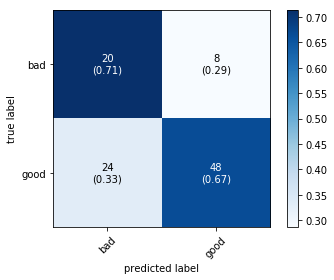

In [81]:
m = confusion_matrix(final['Risk'], final['predicted'])
multiclass = np.array(m)
class_names = ['bad', 'good']

fig, ax = plot_confusion_matrix(conf_mat=multiclass,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                                class_names=class_names)
plt.show()